In [109]:
import pandas as pd
import matplotlib.pyplot as plt

In [110]:
########## Purchase plan strategy

In [111]:
busiest_day= pd.read_csv(r'../../results/busiest-day-trips-info.csv', low_memory=False)

In [112]:
# Assuming busiest_day is your dataframe
busiest_day['Route'] = busiest_day['Route'].str.replace(r'\(X\)', '', regex=True) # replace (X)
busiest_day['Route'] = busiest_day['Route'].str.replace('X', '', regex=False) # replace X

In [113]:
### PP High-cap Scenario

In [114]:
h_PP_variables = pd.read_csv(r'../../results/highcap-PP-optimized-variables.csv', low_memory=False)

In [115]:
h_PP_coefficients = pd.read_csv(r'../../results/optimization-coefficients.csv', low_memory=False)

In [116]:
# Extract attributes from h_PP_variables
h_PP_variables[['Powertrain', 'Scenario', 'Year', 'Trip']] = h_PP_variables['Variable'].str.extract(r'x_(\w+)\[(\w+-cap),(\d+),(\d+)\]')
h_PP_variables = h_PP_variables.dropna()
h_PP_variables['Year'] = h_PP_variables['Year'].astype(int).copy()
# Convert 'Trip' columns to string type for both dataframes (ensure consistency)
h_PP_variables['Trip'] = h_PP_variables['Trip'].astype(str)
busiest_day['TripKey'] = busiest_day['TripKey'].astype(str)


# Extract attributes from h_PP_coefficients
h_PP_coefficients[['Scenario', 'Year', 'Trip']] = h_PP_coefficients['Variable'].str.extract(r"\('(\w+-\w+)', (\d+), (\d+)\)")
h_PP_coefficients = h_PP_coefficients.dropna()
h_PP_coefficients['Year'] = h_PP_coefficients['Year'].astype(int)

# Convert 'Trip' columns to string type for both dataframes (ensure consistency)
h_PP_variables['Trip'] = h_PP_variables['Trip'].astype(str)
h_PP_coefficients['Trip'] = h_PP_coefficients['Trip'].astype(str)

# Merge the dataframes on matching values
merged_df = h_PP_variables.merge(h_PP_coefficients[['Powertrain','Year', 'Trip', 'Coefficient']],
                                on=['Powertrain','Year', 'Trip',],
                                how='left')

# Update h_PP_variables
h_PP_variables = merged_df

In [117]:
# Merge the dataframes on matching values
merged_df = h_PP_variables.merge(busiest_day[['TripKey', 'Route', 'Stop_first', 'Stop_last', 'ServiceDateTime_min', 'ServiceDateTime_max', 'dist']], 
                                 left_on='Trip', 
                                 right_on='TripKey', 
                                 how='left')

# Drop the TripKey column if not needed
merged_df.drop(columns='TripKey', inplace=True)

# Update h_PP_variables
h_PP_variables = merged_df

h_PP_variables['ServiceDateTime_min'] = pd.to_datetime(h_PP_variables['ServiceDateTime_min'])
h_PP_variables['ServiceDateTime_max'] = pd.to_datetime(h_PP_variables['ServiceDateTime_max'])
#h_PP_variables['Value'] = pd.to_numeric(h_PP_variables['Value'])

In [118]:
h_PP_variables.to_csv(r'../../results/highcap-PP-optimized-variables-aggregated.csv', index=False)

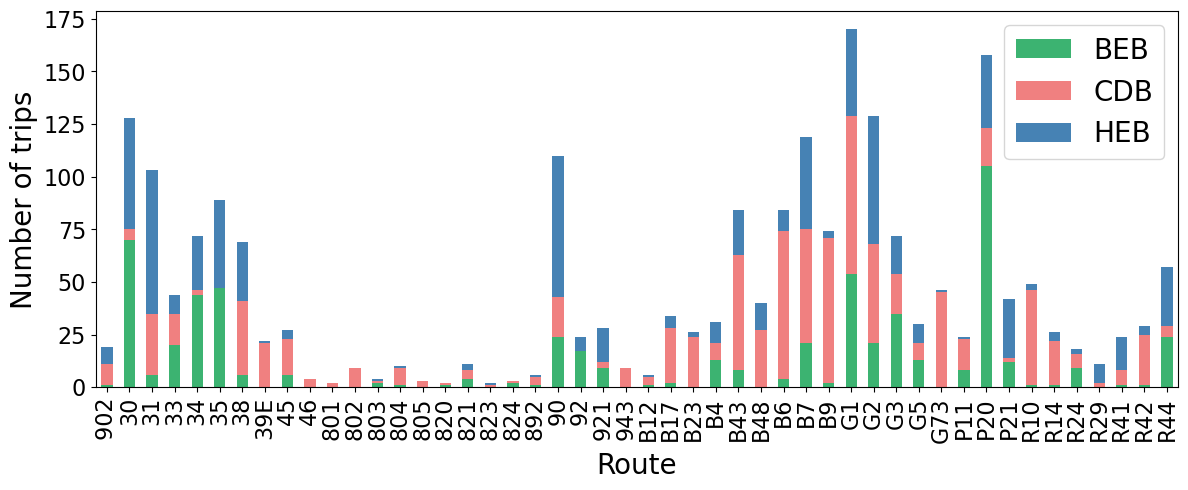

In [119]:
# Filter the dataframe for Year=13 and Value=1
h_PP_variables_filtered = h_PP_variables[(h_PP_variables['Year'] == 12) & (h_PP_variables['Value'] == 1)]
h_PP_variables_filtered = h_PP_variables_filtered[h_PP_variables_filtered['Route'] != '9999']

# Group by Route and Powertrain to count unique trips
grouped_trips = h_PP_variables_filtered.groupby(['Route', 'Powertrain'])['Trip'].nunique().unstack(fill_value=0)

# Plot
# Create a figure and a set of subplots with larger size
fig, ax = plt.subplots(figsize=(12, 5))

colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}
ax = grouped_trips.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped_trips.columns], ax=ax)

# Annotate with BEB percentages
for index, (route, row) in enumerate(grouped_trips.iterrows()):
    total = row.sum()
    BEB_count = row.get('BEB', 0)
    percentage = (BEB_count / total) * 100
    
# Set the title and labels with larger font sizes
ax.set_xlabel('Route', fontsize=20)
ax.set_ylabel('Number of trips', fontsize=20)
ax.legend(fontsize=20)
#ax.set_xlabel('')
#ax.set_xticks([])
# Increase the font size for tick labels
ax.tick_params(axis='both', labelsize=16)

plt.tight_layout()

fig.savefig(r'../../figures/h_PP_route_electrification.png', dpi=400)  

plt.show()


In [120]:
# Compute the total BEB counts and total trips
total_BEB_counts = grouped_trips['BEB'].sum()
total_trips = grouped_trips.sum(axis=1).sum()

# Calculate average %BEB across all routes
average_percentage_BEB = (total_BEB_counts / total_trips) * 100

print(f"Average %BEB across all routes: {average_percentage_BEB:.2f}%")


Average %BEB across all routes: 27.35%


In [121]:
h_PP_variables_y = pd.read_csv(r'../../results/highcap-PP-optimized-variables-y.csv', low_memory=False)

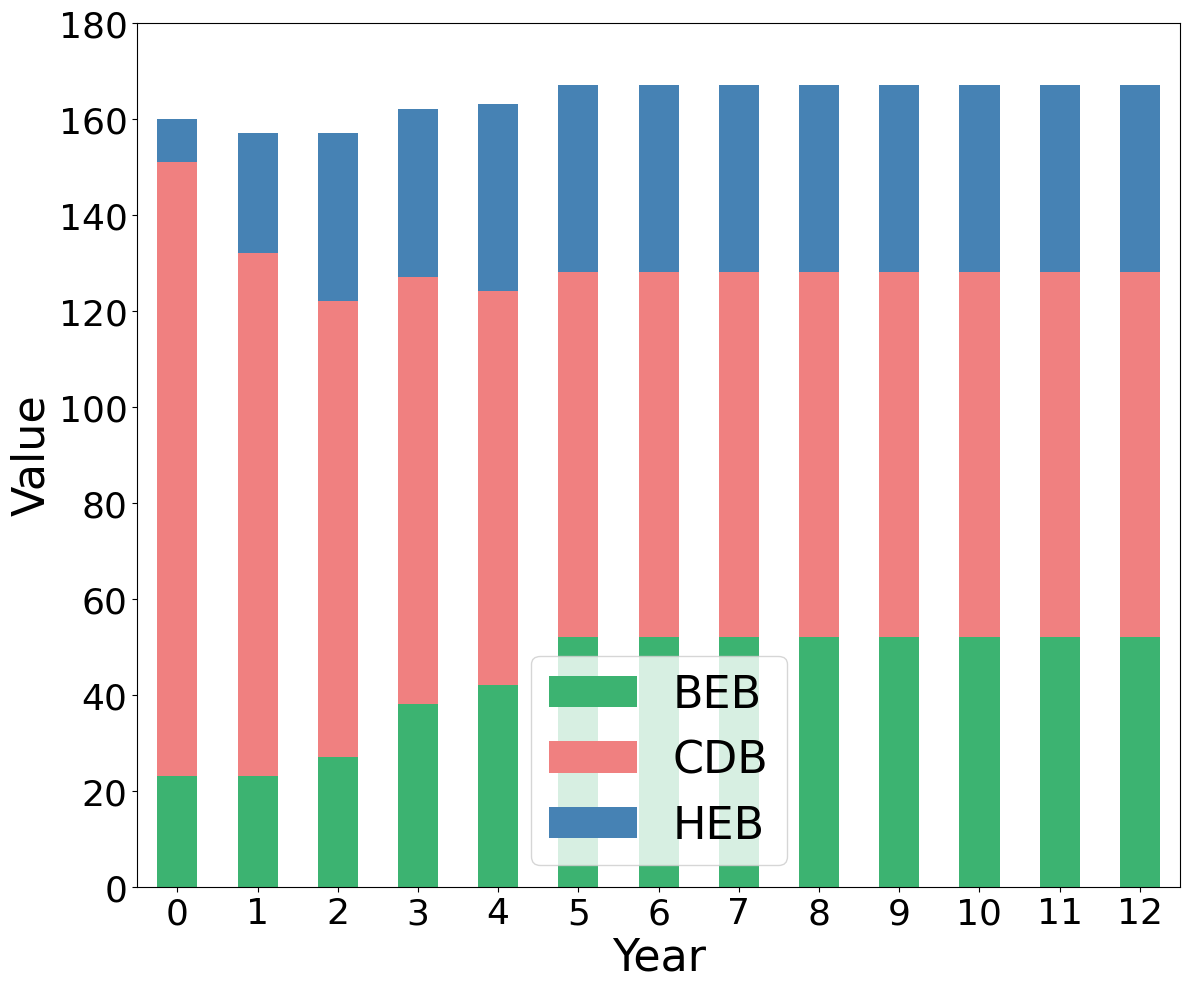

In [122]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by Year and Powertrain to sum up the Value
grouped_values = h_PP_variables_y.groupby(['Year', 'Powertrain'])['Value'].sum().unstack(fill_value=0)

# Plot
fig, ax = plt.subplots(figsize=(12, 10))

colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}
ax = grouped_values.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped_values.columns], ax=ax)

# Annotate bars with the segment values
#for container in ax.containers:
#    for rect in container:
#        height = rect.get_height()
#        ax.annotate(f'{int(height)}',  # Dropped the decimals by converting to int
#                    xy=(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2),
#                    ha='center', 
#                    va='center',
#                    color='black',  
#                    fontsize=18)

# Set the title and labels with larger font sizes
ax.set_xlabel('Year', fontsize=32)
ax.set_ylabel('Value', fontsize=32)
ax.legend(fontsize=32)
ax.set_xticklabels(grouped_values.index, rotation=0)
ax.set_ylim(0, 180)

# Increase the font size for tick labels
ax.tick_params(axis='both', labelsize=26)

plt.tight_layout()

fig.savefig(r'../../figures/h_PP_fleet.png', dpi=400)  

plt.show()


In [107]:
total_sum = (h_PP_variables['Value'] * h_PP_variables['Coefficient']).sum()
print(total_sum)

28249.07487249279


In [39]:
### PP Mid-cap Scenario

In [40]:
m_PP_variables = pd.read_csv(r'../../results/midcap-PP-optimized-variables.csv', low_memory=False)

In [41]:
m_PP_coefficients = pd.read_csv(r'../../results/optimization-coefficients.csv', low_memory=False)

In [42]:
# Extract attributes from m_PP_variables
m_PP_variables[['Powertrain', 'Scenario', 'Year', 'Trip']] = m_PP_variables['Variable'].str.extract(r'x_(\w+)\[(\w+-cap),(\d+),(\d+)\]')
m_PP_variables = m_PP_variables.dropna()
m_PP_variables['Year'] = m_PP_variables['Year'].astype(int).copy()
# Convert 'Trip' columns to string type for both dataframes (ensure consistency)
m_PP_variables['Trip'] = m_PP_variables['Trip'].astype(str)
busiest_day['TripKey'] = busiest_day['TripKey'].astype(str)


# Extract attributes from m_PP_coefficients
m_PP_coefficients[['Scenario', 'Year', 'Trip']] = m_PP_coefficients['Variable'].str.extract(r"\('(\w+-\w+)', (\d+), (\d+)\)")
m_PP_coefficients = m_PP_coefficients.dropna()
m_PP_coefficients['Year'] = m_PP_coefficients['Year'].astype(int)

# Convert 'Trip' columns to string type for both dataframes (ensure consistency)
m_PP_variables['Trip'] = m_PP_variables['Trip'].astype(str)
m_PP_coefficients['Trip'] = m_PP_coefficients['Trip'].astype(str)

# Merge the dataframes on matching values
merged_df = m_PP_variables.merge(m_PP_coefficients[['Powertrain','Year', 'Trip', 'Coefficient']],
                                on=['Powertrain','Year', 'Trip',],
                                how='left')

# Update m_PP_variables
m_PP_variables = merged_df

In [43]:
# Merge the dataframes on matching values
merged_df = m_PP_variables.merge(busiest_day[['TripKey', 'Route', 'Stop_first', 'Stop_last', 'ServiceDateTime_min', 'ServiceDateTime_max', 'dist']], 
                                 left_on='Trip', 
                                 right_on='TripKey', 
                                 how='left')

# Drop the TripKey column if not needed
merged_df.drop(columns='TripKey', inplace=True)

# Update h_PP_variables
m_PP_variables = merged_df

m_PP_variables['ServiceDateTime_min'] = pd.to_datetime(m_PP_variables['ServiceDateTime_min'])
m_PP_variables['ServiceDateTime_max'] = pd.to_datetime(m_PP_variables['ServiceDateTime_max'])
#h_PP_variables['Value'] = pd.to_numeric(h_PP_variables['Value'])

In [44]:
m_PP_coefficients

,Powertrain,Variable,Coefficient,Scenario,Year,Trip
0,CDB,"('high-cap', 0, 504451)",0.247132,high-cap,0,504451
1,CDB,"('high-cap', 1, 504451)",0.247132,high-cap,1,504451
2,CDB,"('high-cap', 2, 504451)",0.247132,high-cap,2,504451
3,CDB,"('high-cap', 3, 504451)",0.247132,high-cap,3,504451
4,CDB,"('high-cap', 4, 504451)",0.247132,high-cap,4,504451
...,...,...,...,...,...,...
99367,BEB,"('high-cap', 9, 507069)",0.000000,high-cap,9,507069
99368,BEB,"('high-cap', 10, 507069)",0.000000,high-cap,10,507069
99369,BEB,"('high-cap', 11, 507069)",0.000000,high-cap,11,507069
99370,BEB,"('high-cap', 12, 507069)",0.000000,high-cap,12,507069


In [45]:
m_PP_variables.to_csv(r'../../results/midcap-PP-optimized-variables-aggregated.csv', index=False)

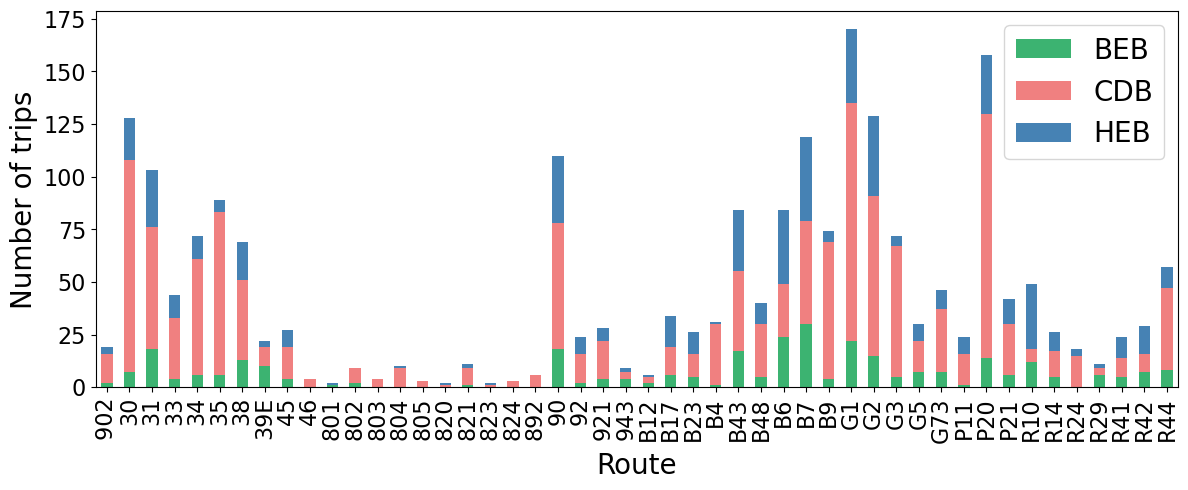

In [46]:
# Filter the dataframe for Year=13 and Value=1
m_PP_variables_filtered = m_PP_variables[(m_PP_variables['Year'] == 12) & (m_PP_variables['Value'] == 1)]
m_PP_variables_filtered = m_PP_variables_filtered[m_PP_variables_filtered['Route'] != '9999']

# Group by Route and Powertrain to count unique trips
grouped_trips = m_PP_variables_filtered.groupby(['Route', 'Powertrain'])['Trip'].nunique().unstack(fill_value=0)

# Plot
# Create a figure and a set of subplots with larger size
fig, ax = plt.subplots(figsize=(12, 5))

colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}
ax = grouped_trips.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped_trips.columns], ax=ax)

# Annotate with BEB percentages
for index, (route, row) in enumerate(grouped_trips.iterrows()):
    total = row.sum()
    BEB_count = row.get('BEB', 0)
    percentage = (BEB_count / total) * 100
    #ax.text(index, row['CDB'] + row['HEB'] + (0.5 * BEB_count), f'{percentage:.1f}%', ha='center', color='white', fontsize=10)
    
# Set the title and labels with larger font sizes
ax.set_xlabel('Route', fontsize=20)
ax.set_ylabel('Number of trips', fontsize=20)
ax.legend(fontsize=20)

# Increase the font size for tick labels
ax.tick_params(axis='both', labelsize=16)

plt.tight_layout()
fig.savefig(r'../../figures/m_PP_route_electrification.png', dpi=400)  

plt.show()


In [47]:
# Compute the total BEB counts and total trips
total_BEB_counts = grouped_trips['BEB'].sum()
total_trips = grouped_trips.sum(axis=1).sum()

# Calculate average %BEB across all routes
average_percentage_BEB = (total_BEB_counts / total_trips) * 100

print(f"Average %BEB across all routes: {average_percentage_BEB:.2f}%")


Average %BEB across all routes: 14.48%


In [48]:
m_PP_variables_y = pd.read_csv(r'../../results/midcap-PP-optimized-variables-y.csv', low_memory=False)

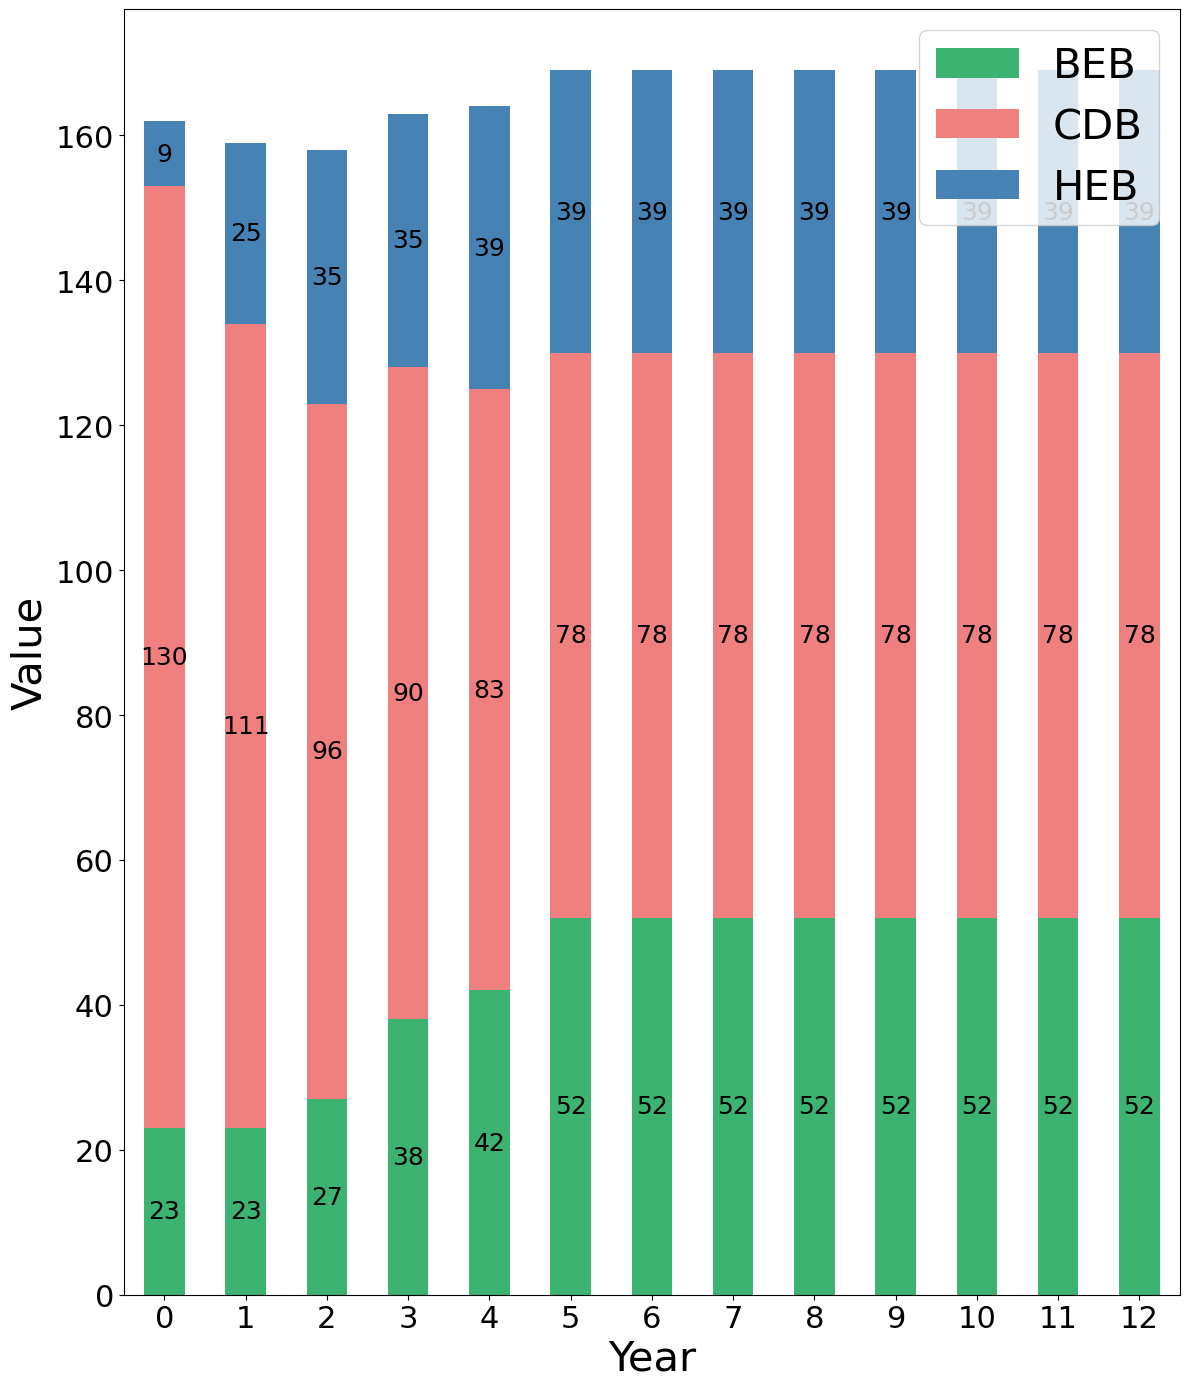

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by Year and Powertrain to sum up the Value
grouped_values = m_PP_variables_y.groupby(['Year', 'Powertrain'])['Value'].sum().unstack(fill_value=0)

# Plot
fig, ax = plt.subplots(figsize=(12, 14))

colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}
ax = grouped_values.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped_values.columns], ax=ax)

# Annotate bars with the segment values
for container in ax.containers:
    for rect in container:
        height = rect.get_height()
        ax.annotate(f'{int(height)}',  # Dropped the decimals by converting to int
                    xy=(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2),
                    ha='center', 
                    va='center',
                    color='black',  
                    fontsize=18)    

# Set the title and labels with larger font sizes
ax.set_xlabel('Year', fontsize=30)
ax.set_ylabel('Value', fontsize=30)
ax.legend(fontsize=30)
ax.set_xticklabels(grouped_values.index, rotation=0)
#ax.set_ylim(0, 255)

# Increase the font size for tick labels
ax.tick_params(axis='both', labelsize=22)
plt.tight_layout()

fig.savefig(r'../../figures/m_PP_fleet.png', dpi=400)  

plt.show()

In [63]:
total_sum = (m_PP_variables['Value'] * m_PP_variables['Coefficient']).sum()
print(total_sum)

39324.999784063


In [64]:
### PP Low-cap Scenario

In [65]:
l_PP_variables = pd.read_csv(r'../../results/lowcap-PP-optimized-variables.csv', low_memory=False)

In [66]:
l_PP_coefficients = pd.read_csv(r'../../results/optimization-coefficients.csv', low_memory=False)

In [67]:
# Extract attributes from l_PP_variables
l_PP_variables[['Powertrain', 'Scenario', 'Year', 'Trip']] = l_PP_variables['Variable'].str.extract(r'x_(\w+)\[(\w+-cap),(\d+),(\d+)\]')
l_PP_variables = l_PP_variables.dropna()
l_PP_variables['Year'] = l_PP_variables['Year'].astype(int)
# Convert 'Trip' columns to string type for both dataframes (ensure consistency)
l_PP_variables['Trip'] = l_PP_variables['Trip'].astype(str)

# Extract attributes from h_PP_coefficients
l_PP_coefficients[['Scenario', 'Year', 'Trip']] = l_PP_coefficients['Variable'].str.extract(r"\('(\w+-\w+)', (\d+), (\d+)\)")
l_PP_coefficients = l_PP_coefficients.dropna()
l_PP_coefficients['Year'] = l_PP_coefficients['Year'].astype(int)

# Convert 'Trip' columns to string type for both dataframes (ensure consistency)
l_PP_variables['Trip'] = l_PP_variables['Trip'].astype(str)
l_PP_coefficients['Trip'] = l_PP_coefficients['Trip'].astype(str)

# Merge the dataframes on matching values
merged_df = l_PP_variables.merge(l_PP_coefficients[['Powertrain','Year', 'Trip', 'Coefficient']],
                                on=['Powertrain','Year', 'Trip',],
                                how='left')

# Update l_PP_variables
l_PP_variables = merged_df

In [68]:
# Merge the dataframes on matching values
merged_df = l_PP_variables.merge(busiest_day[['TripKey', 'Route', 'Stop_first', 'Stop_last', 'ServiceDateTime_min', 'ServiceDateTime_max', 'dist']], 
                                 left_on='Trip', 
                                 right_on='TripKey', 
                                 how='left')

# Drop the TripKey column if not needed
merged_df.drop(columns='TripKey', inplace=True)

# Update l_PP_variables
l_PP_variables = merged_df

l_PP_variables['ServiceDateTime_min'] = pd.to_datetime(l_PP_variables['ServiceDateTime_min'])
l_PP_variables['ServiceDateTime_max'] = pd.to_datetime(l_PP_variables['ServiceDateTime_max'])

In [69]:
l_PP_variables.to_csv(r'../../results/lowcap-PP-optimized-variables-aggregated.csv', index=False)

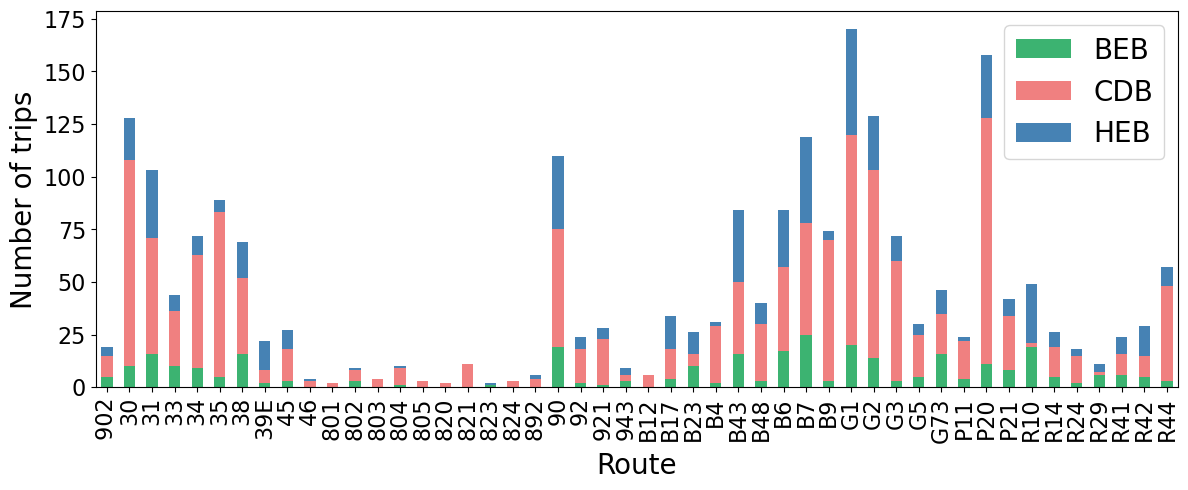

In [70]:
# Filter the dataframe for Year=13 and Value=1
l_PP_variables_filtered = l_PP_variables[(l_PP_variables['Year'] == 12) & (l_PP_variables['Value'] == 1)]
l_PP_variables_filtered = l_PP_variables_filtered[l_PP_variables_filtered['Route'] != '9999']

# Group by Route and Powertrain to count unique trips
grouped_trips = l_PP_variables_filtered.groupby(['Route', 'Powertrain'])['Trip'].nunique().unstack(fill_value=0)

# Plot
# Create a figure and a set of subplots with larger size
fig, ax = plt.subplots(figsize=(12, 5))

colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}
ax = grouped_trips.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped_trips.columns], ax=ax)

# Annotate with BEB percentages
for index, (route, row) in enumerate(grouped_trips.iterrows()):
    total = row.sum()
    BEB_count = row.get('BEB', 0)
    percentage = (BEB_count / total) * 100
    #ax.text(index, row['CDB'] + row['HEB'] + (0.5 * BEB_count), f'{percentage:.1f}%', ha='center', color='white', fontsize=10)
    
# Set the title and labels with larger font sizes
ax.set_xlabel('Route', fontsize=20)
ax.set_ylabel('Number of trips', fontsize=20)
ax.legend(fontsize=20)

# Increase the font size for tick labels
ax.tick_params(axis='both', labelsize=16)

plt.tight_layout()
fig.savefig(r'../../figures/l_PP_route_electrification.png', dpi=400)  

plt.show()


In [71]:
# Compute the total BEB counts and total trips
total_BEB_counts = grouped_trips['BEB'].sum()
total_trips = grouped_trips.sum(axis=1).sum()

# Calculate average %BEB across all routes
average_percentage_BEB = (total_BEB_counts / total_trips) * 100

print(f"Average %BEB across all routes: {average_percentage_BEB:.2f}%")


Average %BEB across all routes: 14.34%


In [72]:
l_PP_variables_y = pd.read_csv(r'../../results/lowcap-PP-optimized-variables-y.csv', low_memory=False)

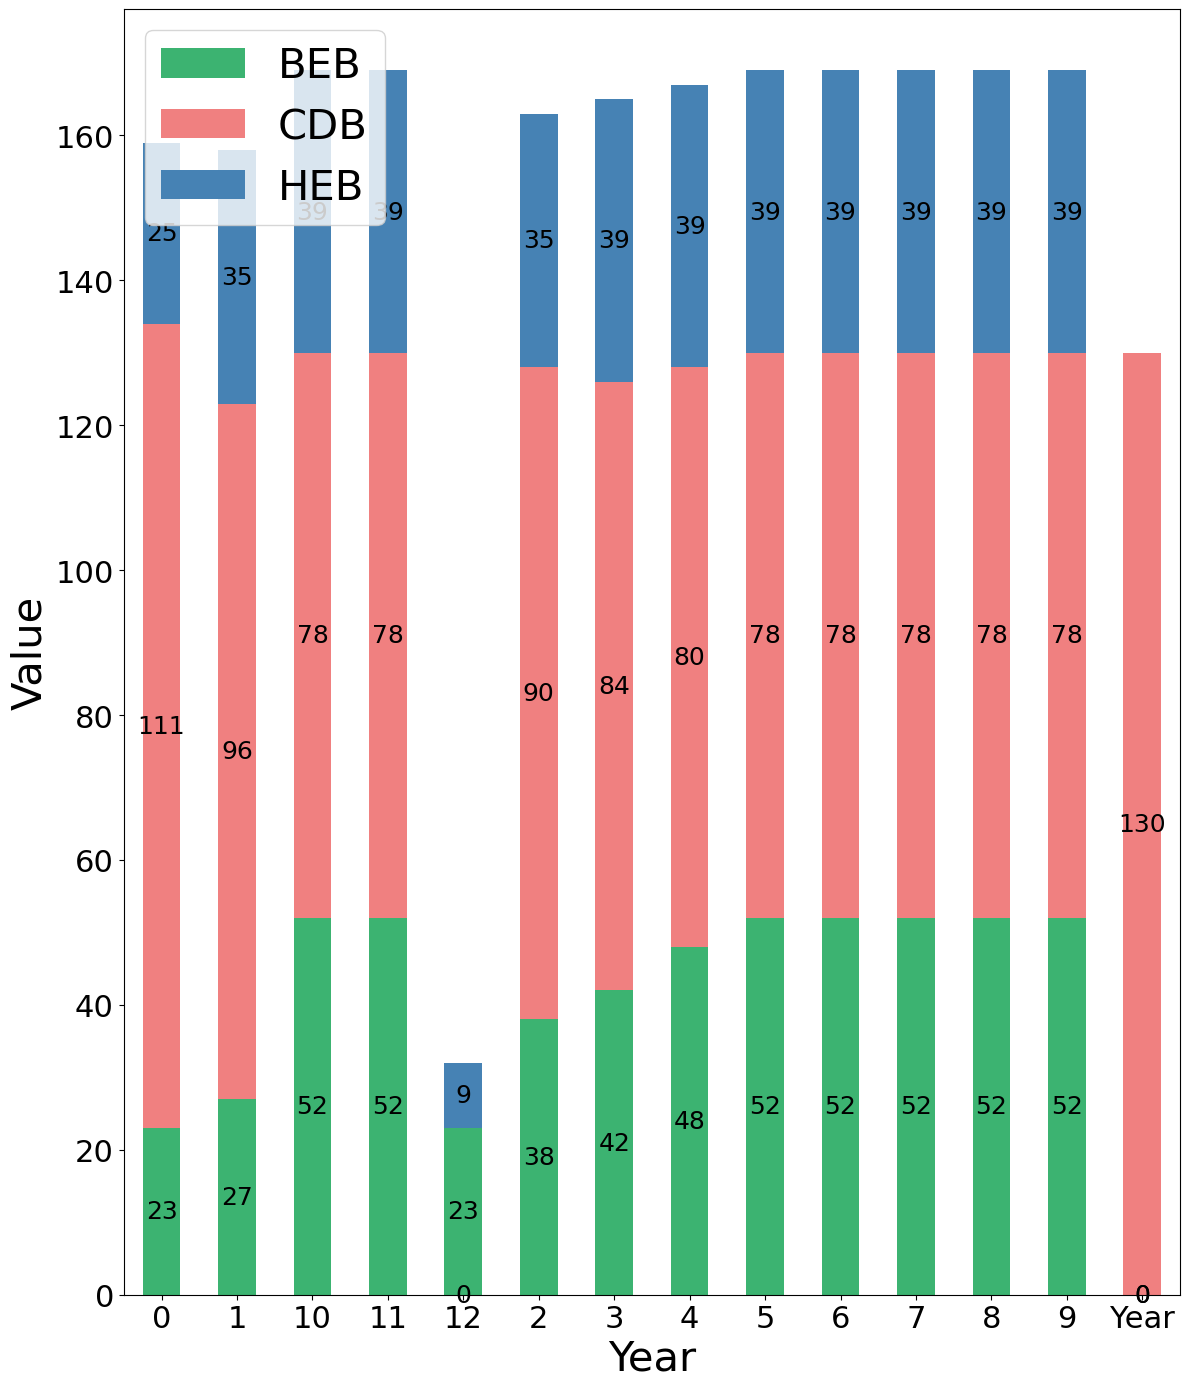

In [73]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by Year and Powertrain to sum up the Value
grouped_values = l_PP_variables_y.groupby(['Year', 'Powertrain'])['Value'].sum().unstack(fill_value=0)

# Plot
fig, ax = plt.subplots(figsize=(12, 14))

colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}
ax = grouped_values.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped_values.columns], ax=ax)

# Annotate bars with the segment values
for container in ax.containers:
    for rect in container:
        height = rect.get_height()
        ax.annotate(f'{int(height)}',  # Dropped the decimals by converting to int
                    xy=(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2),
                    ha='center', 
                    va='center',
                    color='black',  
                    fontsize=18)

# Set the title and labels with larger font sizes
ax.set_xlabel('Year', fontsize=30)
ax.set_ylabel('Value', fontsize=30)
ax.legend(loc='upper left', fontsize=30)
ax.set_xticklabels(grouped_values.index, rotation=0)

# Increase the font size for tick labels
ax.tick_params(axis='both', labelsize=22)
#ax.set_ylim(0, 255)

plt.tight_layout()

# Save the figure
fig.savefig(r'../../figures/l_PP_fleet.png', dpi=400)  

plt.show()


In [74]:
total_sum = (l_PP_variables['Value'] * l_PP_variables['Coefficient']).sum()
print(total_sum)

39184.956231706


In [108]:
# Calculate sum for each Year for each DataFrame
h_PP_variables['Result'] = h_PP_variables['Value'] * h_PP_variables['Coefficient']
h_PP_sum = h_PP_variables.groupby('Year')['Result'].sum().reset_index()

# Add Scenario and Strategy columns
h_PP_sum['Scenario'] = 'h'
h_PP_sum['Strategy'] = 'PP'

# Concatenate the DataFrames
final_df = h_PP_sum.copy()

# Rearrange the columns
final_df = final_df[['Year', 'Result', 'Scenario', 'Strategy']]
final_df.to_csv(r'../../results/diesel-PP.csv', index=False)